### Atlantic Exercise 

By Daniel Elkin

In [1]:
import numpy as np
import matplotlib as plt
import pandas as pd

In [4]:
%matplotlib inline

In [63]:
def plot_df(df, target_col, title, xlab, ylab):
    grouped = df.groupby(target_col) \
        .count()[["visitor_id"]] \
        .rename(columns={"visitor_id": "count"})
    
    ax = grouped.plot(
                title=title,
                figsize=(10, 5))
    
    ax.get_legend().remove()
    ax.set_xlabel("Hour of publication (24-hr clock)")
    ax.set_ylabel("Number of articles")

### I. Data preparation

Create a dataframe from the data, skipping malformed rows and converting the date columns to datetimes.

In [2]:
df = pd.read_csv("data/analyst_hw.tsv",
                     delim_whitespace=True,
                     error_bad_lines=False,
                     header=0, 
                     parse_dates=["visit_date", "publication_date"])


b'Skipping line 249069: expected 7 fields, saw 16\n'
b'Skipping line 626179: expected 7 fields, saw 9\n'
b'Skipping line 1133126: expected 7 fields, saw 22\n'
b'Skipping line 1198292: expected 7 fields, saw 13\nSkipping line 1286414: expected 7 fields, saw 28\n'
b'Skipping line 1783537: expected 7 fields, saw 33\n'
b'Skipping line 1975238: expected 7 fields, saw 17\n'


Inspect the dataframe.

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001871 entries, 0 to 2001870
Data columns (total 7 columns):
visitor_id          object
visit_date          datetime64[ns]
visit_hour          int64
url_id              object
site_section        object
publication_date    datetime64[ns]
publication_hour    int64
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 106.9+ MB


In [73]:
df.head()

,visitor_id,visit_date,visit_hour,url_id,site_section,publication_date,publication_hour
0,SNSMrjUkQw/foPv5hRQVpQ==,2018-03-12,17,+VAVDTcwiN39A1wI+AMfAQ==,/technology/,2018-03-12,15
1,7ZmbLaKLEhf0XIVwICyiSA==,2018-03-12,10,2mXxdmD6ysfWw82+9T6OlA==,/business/,2018-02-22,12
2,rGzdTSm1D6K6BEQHOEQ37g==,2018-03-12,17,RJkBuEQLELyj66QjJkg1uA==,/business/,2018-03-11,15
3,3IlL9al+8Gr+ORA5w7oU6Q==,2018-03-12,11,uGrr1+tQEYsPD0t4tJg0rg==,/magazine/,2018-03-06,15
4,sf9ahOgrG7K4yHmnSE/nOg==,2018-03-12,12,uGrr1+tQEYsPD0t4tJg0rg==,/magazine/,2018-03-06,15


The file was parsed correctly and the datetimes were successfully converted. There are over two million rows to analyze.

### II. Data exploration

Inspect the key variables of interest.

In [96]:
cols = ["publication_date", "publication_hour", "visit_date", "visit_hour", "site_section"]
df[cols].describe(include="all")

,publication_date,publication_hour,visit_date,visit_hour,site_section
count,2001871,2.001871e+06,2001871,2.001871e+06,2001871
unique,73,NaN,31,NaN,736
top,2018-02-26 00:00:00,NaN,2018-03-13 00:00:00,NaN,/politics/
freq,350205,NaN,81236,NaN,316348
first,2018-01-15 00:00:00,NaN,2018-03-01 00:00:00,NaN,NaN
last,2018-03-31 00:00:00,NaN,2018-03-31 00:00:00,NaN,NaN
mean,NaN,1.268171e+01,NaN,1.350084e+01,NaN
std,NaN,2.556255e+00,NaN,3.450397e+00,NaN
min,NaN,4.000000e+00,NaN,8.000000e+00,NaN
25%,NaN,1.100000e+01,NaN,1.100000e+01,NaN


We see from the counts that there is complete data for each variable and that we have articles published between mid-January and the end of March 2018 and visitor data for the month of March. 

Politics appears to be the most-visited section, but one oddity is the large number of unique sections. Examining the unique values reveals that sections may not have been extracted correctly from pages that were translated. This may be something we would want to cleanup.

In [117]:
df[df["site_section"].str.contains("translate")].site_section.head()

111      /translate_c?depth=1&hl=hi&nv=1&prev=search&ru...
13518    /translate_c?depth=1&hl=es&prev=search&rurl=tr...
34353    /translate_c?depth=1&hl=fr&rurl=translate.goog...
42651    /translate_c?depth=1&hl=fr&prev=search&rurl=tr...
44604    /translate_c?depth=1&hl=zh-CN&ie=UTF8&prev=_t&...
Name: site_section, dtype: object

For now, we'll examine some of the individual variables in more detail to answer the questions from the prompt.

#### a. Publication hour

We'll first look at the times of day when articles tend to be published. From the table above, we know that articles are published between 4:00am and 8:00pm and that they are on average published at around 1:30pm, but let's visualize the distribution.

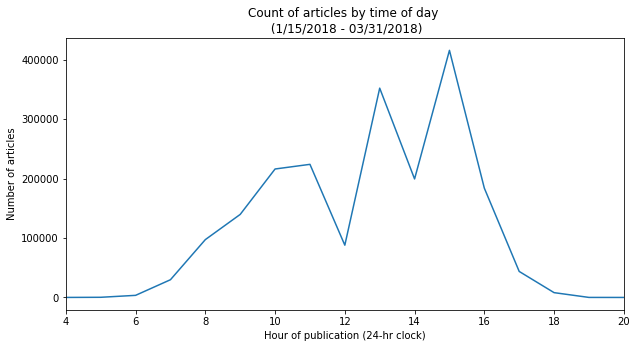

In [55]:
grouped = df.groupby("publication_hour") \
        .count()[["visitor_id"]] \
        .rename(columns={"visitor_id": "count"})

title = "Count of articles by time of day \n (1/15/2018 - 03/31/2018)"
ax = grouped.plot(
            title=title,
            figsize=(10, 5)
    )

ax.set_xlabel("Hour of publication (24-hr clock)")
ax.get_legend().remove()
_ = ax.set_ylabel("Number of articles")

These results look reasonable. Some articles are published in the morning, there is a dip, perhaps for lunch at noon, an then the majority of articles are published in the afternoon. The dip at 2:00pm is somewhat surprising but is perhaps explained by something organization-specific.

In [ ]:
#### b. 

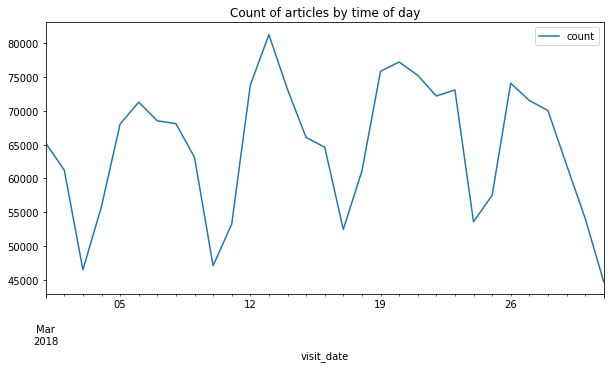

In [57]:
grouped = df.groupby("visit_date") \
        .count()[["visitor_id"]] \
        .rename(columns={"visitor_id": "count"})

title = "Count of articles by time of day"
ax = grouped.plot(
            title=title,
            figsize=(10, 5)
    )


In [62]:
# df.visit_date.dt.day_name()
df[df.publication_date = ]

0          Monday
1          Monday
2          Monday
3          Monday
4          Monday
5          Monday
6          Monday
7          Monday
8          Monday
9          Monday
10         Monday
11         Monday
12         Monday
13         Monday
14         Monday
15         Monday
16         Monday
17         Monday
18         Monday
19         Monday
20         Monday
21         Monday
22         Monday
23         Monday
24         Monday
25         Monday
26         Monday
27         Monday
28         Monday
29         Monday
            ...  
2001841    Friday
2001842    Friday
2001843    Friday
2001844    Friday
2001845    Friday
2001846    Friday
2001847    Friday
2001848    Friday
2001849    Friday
2001850    Friday
2001851    Friday
2001852    Friday
2001853    Friday
2001854    Friday
2001855    Friday
2001856    Friday
2001857    Friday
2001858    Friday
2001859    Friday
2001860    Friday
2001861    Friday
2001862    Friday
2001863    Friday
2001864    Friday
2001865   

#### b. Visit hour

(0, 200000)

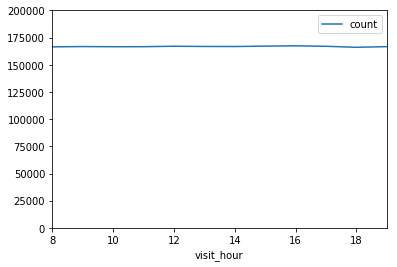

In [31]:
ax = df.groupby("visit_hour") \
        .count()[["visitor_id"]] \
        .rename(columns={"visitor_id": "count"}) \
        .plot()

ax.set_ylim(0, 200000)